# Example

processing and slustering 3K PBMCs

## Step1 Load data
1. sc.settings.verbosity = 3 # verbosity 的取值表示测试结果显示的详细程度，数字越大越详细
2. sc.logging.print_versions() # 输出版本号
3. sc.settings.set_figure_params(dpi=80) # set_figure_params 设置图片的分辨率/大小以及其他样式

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib notebook

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

path_working = "E:\\single_cell\\example\\working_space"
os.chdir(path_working)
results_file = 'pbmc3k.h5ad'  # the file that will store the analysis results

scanpy==1.9.5 anndata==0.10.2 umap==0.5.4 numpy==1.24.3 scipy==1.11.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 pynndescent==0.5.10


In [2]:
# load data
data = sc.read_10x_mtx("E:\\single_cell\\example\\hg19", var_names='gene_symbols',cache=True)
data.var_names_make_unique()   # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
data

... reading from cache file cache\E-single_cell-example-hg19-matrix.h5ad


d:\Users\lee\anaconda3\Lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Step2 Preprocessing

normalizing counts per cell
    finished (0:00:00)


<IPython.core.display.Javascript object>


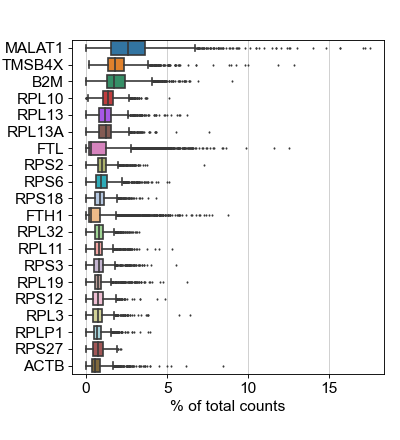

In [3]:
os.makedirs("./step2_preprocessing",exist_ok=True)
sc.pl.highest_expr_genes(data, n_top=20)
plt.savefig("./step2_preprocessing/Highest_expr_genes.pdf",bbox_inches='tight')

In [4]:
## Basic filtering
sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_genes(data, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [5]:
data.var['mt']=data.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(data,qc_vars=['mt'],percent_top=None, log1p=False, inplace=True)

<IPython.core.display.Javascript object>


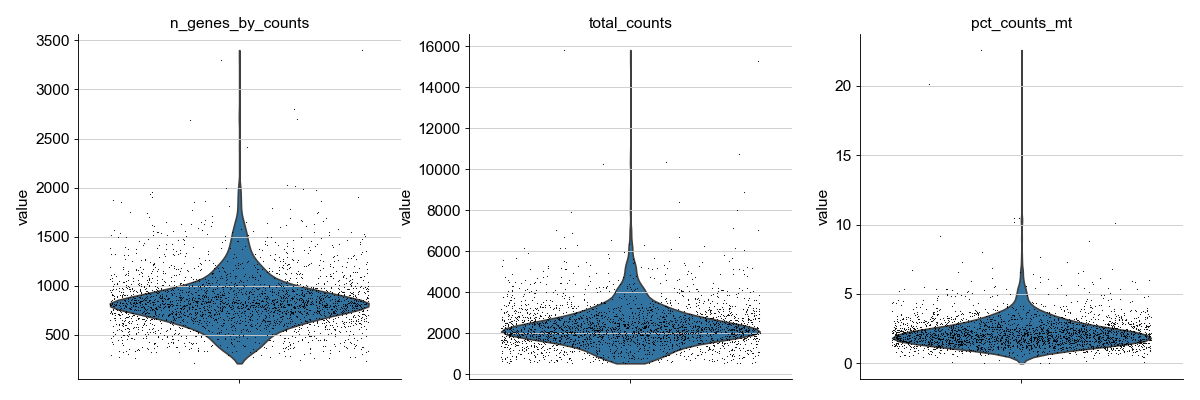

d:\Users\lee\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<IPython.core.display.Javascript object>


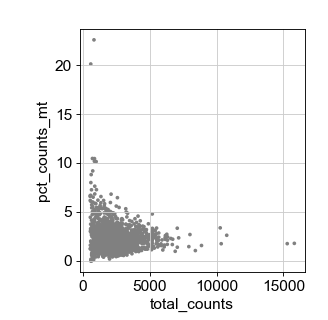

<IPython.core.display.Javascript object>


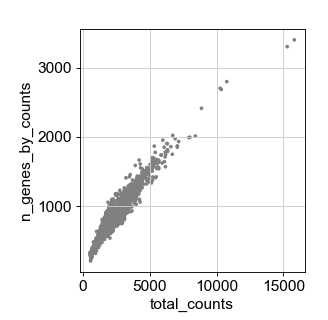

In [7]:
sc.pl.violin(data, ['n_genes_by_counts','total_counts','pct_counts_mt'],
            jitter=0.4,multi_panel=True)
plt.savefig("./step2_preprocessing/violin_filter_all.pdf",bbox_inches='tight')

sc.pl.scatter(data,x="total_counts",y="pct_counts_mt")
plt.savefig("./step2_preprocessing/total_counts-pct_counts_mt.pdf")
sc.pl.scatter(data,x="total_counts",y="n_genes_by_counts")
plt.savefig("./step2_preprocessing/total_counts-ngenes_counts.pdf")

In [8]:
data=data[data.obs.n_genes_by_counts < 2500,:]
data=data[data.obs.pct_counts_mt < 5,:]

In [9]:
sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)
sc.pp.highly_variable_genes(data,min_mean=0.0125, max_mean=3, min_disp=0.5)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


d:\Users\lee\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


<IPython.core.display.Javascript object>


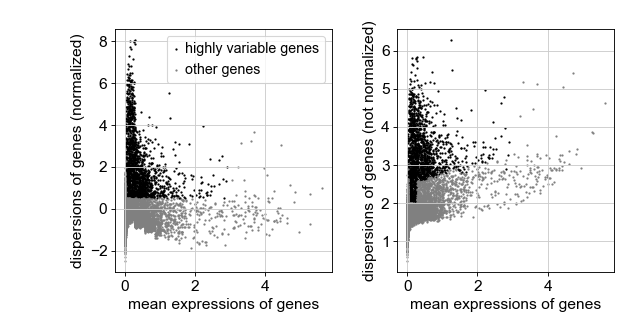

In [10]:
sc.pl.highly_variable_genes(data)

In [11]:
data.raw=data
data=data[:,data.var.highly_variable]
sc.pp.regress_out(data,['total_counts','pct_counts_mt'])
sc.pp.scale(data,max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:05)


## Step3 Principal component analysis



computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


<IPython.core.display.Javascript object>


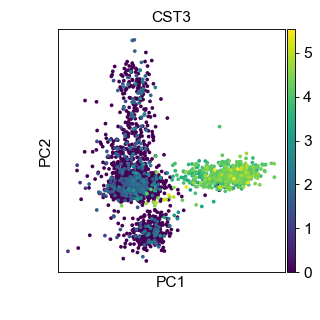

<IPython.core.display.Javascript object>


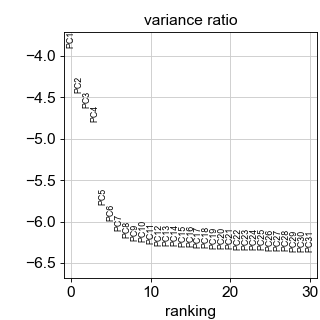

In [24]:
sc.tl.pca(data,svd_solver='arpack')
sc.pl.pca(data,color="CST3")
plt.savefig("./step3_PCA/pca_CST3.pdf")
sc.pl.pca_variance_ratio(data, log=True)
plt.savefig("./step3_PCA/pca_variance.pdf")

In [25]:
data.write(results_file)
data

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Step4: Computing the neighborhood graph

In [3]:
data=sc.read(results_file)
sc.pp.neighbors(data, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40


d:\Users\lee\anaconda3\Lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [7]:
data

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [10]:
sc.tl.leiden(data)
sc.tl.paga(data)
sc.pl.paga(data, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(data, init_pos='paga')

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


<IPython.core.display.Javascript object>


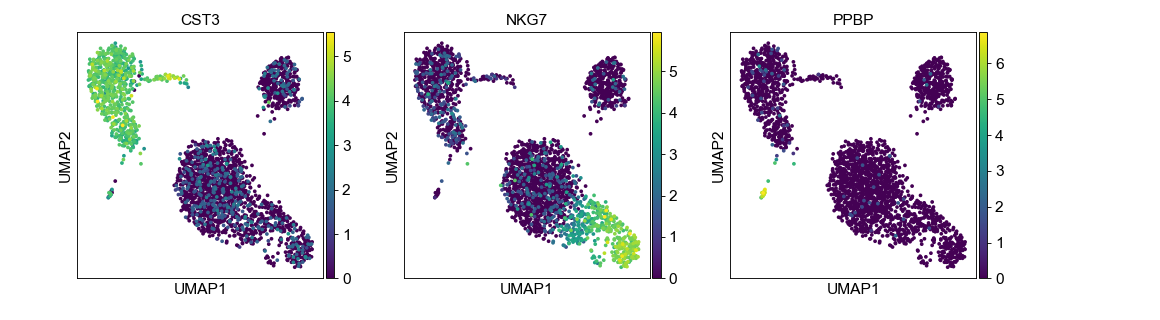

<IPython.core.display.Javascript object>


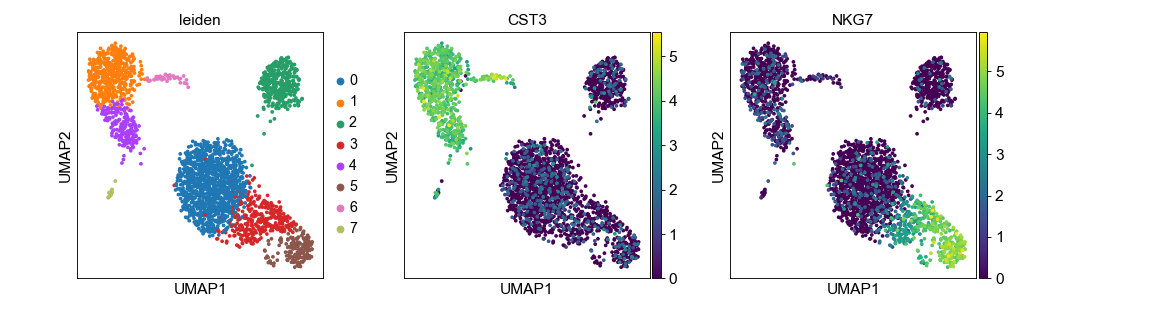

d:\Users\lee\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [13]:
sc.pl.umap(data,color=['CST3','NKG7','PPBP'])
sc.pl.umap(data,color=['leiden','CST3','NKG7'])

## Step5: Finding marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


<IPython.core.display.Javascript object>


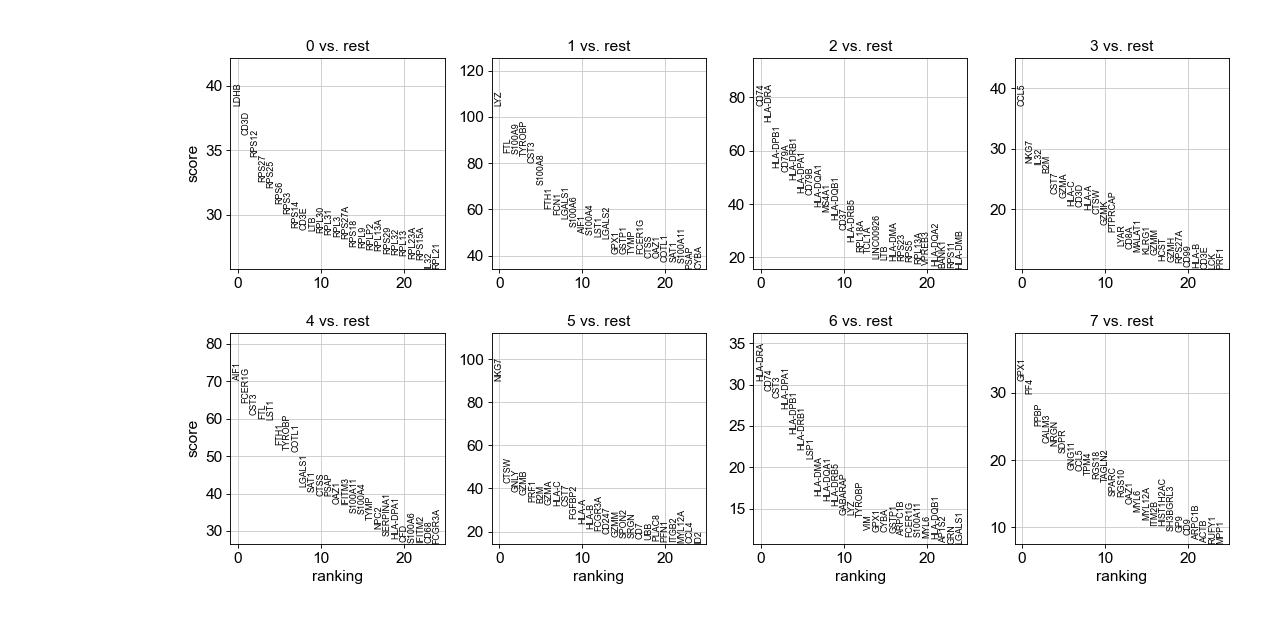

In [14]:
sc.tl.rank_genes_groups(data, 'leiden', method='t-test')
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

ranking genes
    finished (0:00:03)


<IPython.core.display.Javascript object>


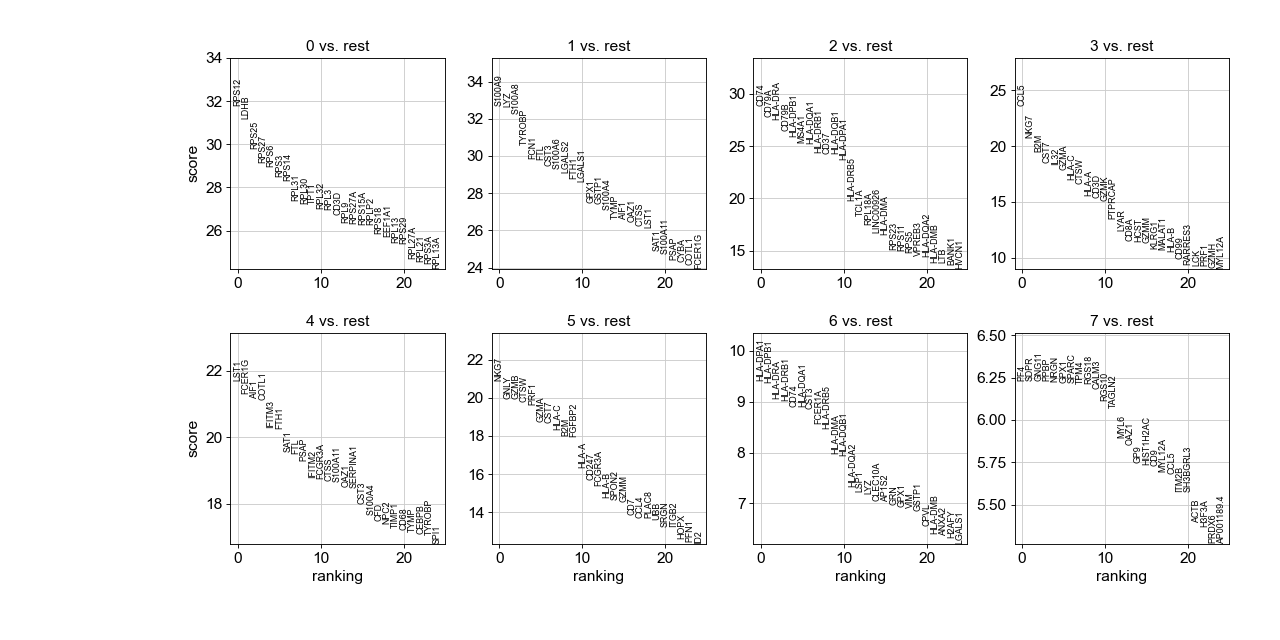

In [15]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

In [18]:
data.write(results_file)
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']
pd.DataFrame(data.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,RPS12,S100A9,CD74,CCL5,LST1,NKG7,HLA-DPA1,PF4
1,LDHB,LYZ,CD79A,NKG7,FCER1G,GNLY,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,B2M,AIF1,GZMB,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,CST7,COTL1,CTSW,HLA-DRB1,PPBP
4,RPS6,FCN1,HLA-DPB1,IL32,IFITM3,PRF1,CD74,NRGN


In [19]:
result = data.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,3.024274e-221,S100A9,5.013557e-234,CD74,3.043536e-182,CCL5,1.477256e-122,LST1,2.733939e-104,NKG7,1.203971e-96,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,2.844985e-213,LYZ,1.276687e-233,CD79A,6.860832e-170,NKG7,1.616002e-95,FCER1G,8.235039e-101,GNLY,1.257170e-88,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,1.417700e-194,S100A8,2.135223e-228,HLA-DRA,8.398068e-166,B2M,3.705727e-84,AIF1,2.582775e-99,GZMB,1.429027e-88,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,7.453292e-187,TYROBP,2.136387e-205,CD79B,1.171444e-153,CST7,2.237884e-76,COTL1,3.696354e-99,CTSW,4.144726e-87,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,2.065737e-184,FCN1,8.605073e-196,HLA-DPB1,6.167786e-148,IL32,7.333215e-75,IFITM3,2.486695e-91,PRF1,1.692100e-85,CD74,5.853161e-19,NRGN,4.800511e-10


In [20]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
data.rename_categories('leiden', new_cluster_names)

<IPython.core.display.Javascript object>


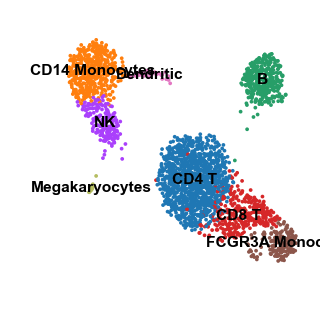

d:\Users\lee\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [22]:
sc.pl.umap(data,color='leiden',legend_loc="on data",title="",frameon=False)

<IPython.core.display.Javascript object>


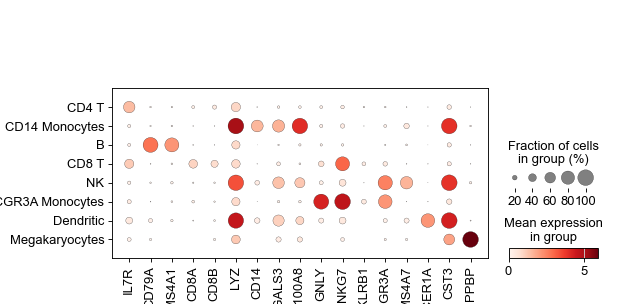

d:\Users\lee\anaconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


In [23]:
sc.pl.dotplot(data, marker_genes, groupby='leiden')

<IPython.core.display.Javascript object>


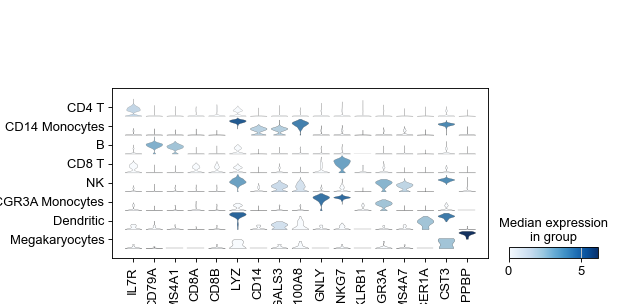

In [24]:
sc.pl.stacked_violin(data, marker_genes, groupby='leiden', rotation=90)

In [25]:
data.write(results_file)